In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

%matplotlib inline

In [2]:
import pandas as pd
energy_weather_df=pd.read_csv(r"/content/drive/MyDrive/energy_weather_df(3).csv")

energy_weather_df.drop(columns=["Unnamed: 0"],inplace=True)
energy_weather_df['hour'] = pd.to_datetime(energy_weather_df['hour'])
energy_weather_df.rename(columns={'hour': 'time'}, inplace=True)
energy_weather_df=energy_weather_df.set_index('time')

In [3]:
energy_weather_df.describe()


,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price actual,madrid_temp,madrid_temp_min,madrid_temp_max,madrid_pressure,madrid_humidity,madrid_wind_speed,madrid_wind_deg,madrid_rain_1h,madrid_rain_3h,madrid_snow_3h,madrid_clouds_all,madrid_weather_id,bilbao_temp,bilbao_temp_min,bilbao_temp_max,bilbao_pressure,bilbao_humidity,bilbao_wind_speed,bilbao_wind_deg,bilbao_rain_1h,bilbao_rain_3h,bilbao_snow_3h,bilbao_clouds_all,bilbao_weather_id,seville_temp,seville_temp_min,seville_temp_max,seville_pressure,seville_humidity,seville_wind_speed,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,barcelona_temp,barcelona_temp_min,barcelona_temp_max,barcelona_pressure,barcelona_humidity,barcelona_wind_speed,barcelona_wind_deg,barcelona_rain_1h,barcelona_rain_3h,barcelona_snow_3h,barcelona_clouds_all,barcelona_weather_id,valencia_temp,valencia_temp_min,valencia_temp_max,valencia_pressure,valencia_humidity,valencia_wind_speed,valencia_wind_deg,valencia_rain_1h,valencia_rain_3h,valencia_snow_3h,valencia_clouds_all,valencia_weather_id
count,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.0,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.0,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000,38567.000000
mean,380.927269,450.028677,5638.142713,4250.305935,297.448440,472.155599,975.663339,2609.983872,6264.434309,59.888143,86.198512,1405.181736,271.058029,5500.523064,28739.597843,58.103470,287.848514,286.606449,288.947256,1014.295823,60.568154,2.444007,173.348951,0.058690,0.000121,0.000027,23.165608,759.767133,286.213068,284.719785,287.912814,1017.277336,78.992921,1.990640,159.020225,0.121277,0.001045,0.021864,44.060103,723.596494,292.864520,290.897730,295.792640,1018.266497,65.024762,2.525579,152.097233,0.051269,0.000166,0.0,15.799233,767.818005,289.588652,288.346544,290.748395,1017.132912,74.347758,2.773278,186.881194,0.115498,0.000301,0.0,23.881323,758.636632,290.536106,289.994067,291.093788,1015.604169,65.760598,2.696761,161.874893,0.037668,0.000206,0.000140,21.390515,779.512848
std,84.708385,353.129197,2209.702780,1957.052126,52.139803,790.483111,401.689140,1838.998627,841.548089,20.074512,14.035924,1659.497172,49.629757,3223.078623,4602.172653,14.211388,9.239940,9.107206,9.586196,13.236093,25.248187,1.985654,122.197986,0.229129,0.002471,0.005342,31.261756,112.648902,6.748348,6.792514,6.902455,9.772183,16.735313,1.899129,122.598164,0.364545,0.014494,0.478210,33.593196,135.130097,7.995002,8.180115,9.020926,7.027577,22.899976,1.921180,104.285288,0.236771,0.003272,0.0,27.559308,95.720225,6.732075,6.479605,7.273374,7.565813,17.574039,2.000269,109.514453,0.676253,0.003816,0.0,28.204097,114.627921,7.170852,7.026855,7.457222,10.347566,19.679755,2.565618,120.755624,0.271906,0.003371,0.011358,25.869661,83.558861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [4]:
energy_weather_df = energy_weather_df[~energy_weather_df.index.duplicated(keep='first')]
monthly_load = energy_weather_df['total load actual'].asfreq('M')


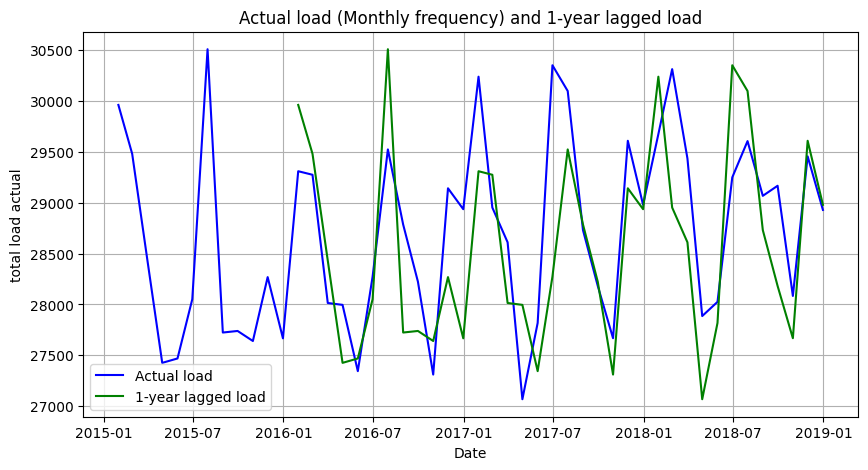

In [5]:
import matplotlib.pyplot as plt

monthly_load = energy_weather_df['total load actual'].resample('M').mean()
shifted = monthly_load.shift(12)

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_load, label='Actual load ', color='blue')
plt.plot(shifted, label='1-year lagged load', color='green')
plt.title('Actual load (Monthly frequency) and 1-year lagged load')
plt.ylabel('total load actual')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
correlations = energy_weather_df.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
generation fossil hard coal                    0.465646
generation fossil gas                          0.461431
total load actual                              0.435589
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285088
generation other renewable                     0.255561
barcelona_pressure                             0.243952
bilbao_pressure                                0.195571
generation waste                               0.168763
generation biomass                             0.142678
valencia_temp_min                              0.133199
barcelona_temp_min                             0.103745
generation other                               0.099890
generation solar                               0.098544
madrid_temp_max                                0.096321
valencia_temp                                  0.090558
seville_pressure                               0

In [7]:
energy_weather_df = energy_weather_df.drop(['barcelona_snow_3h', 'seville_snow_3h'],
                        axis=1)

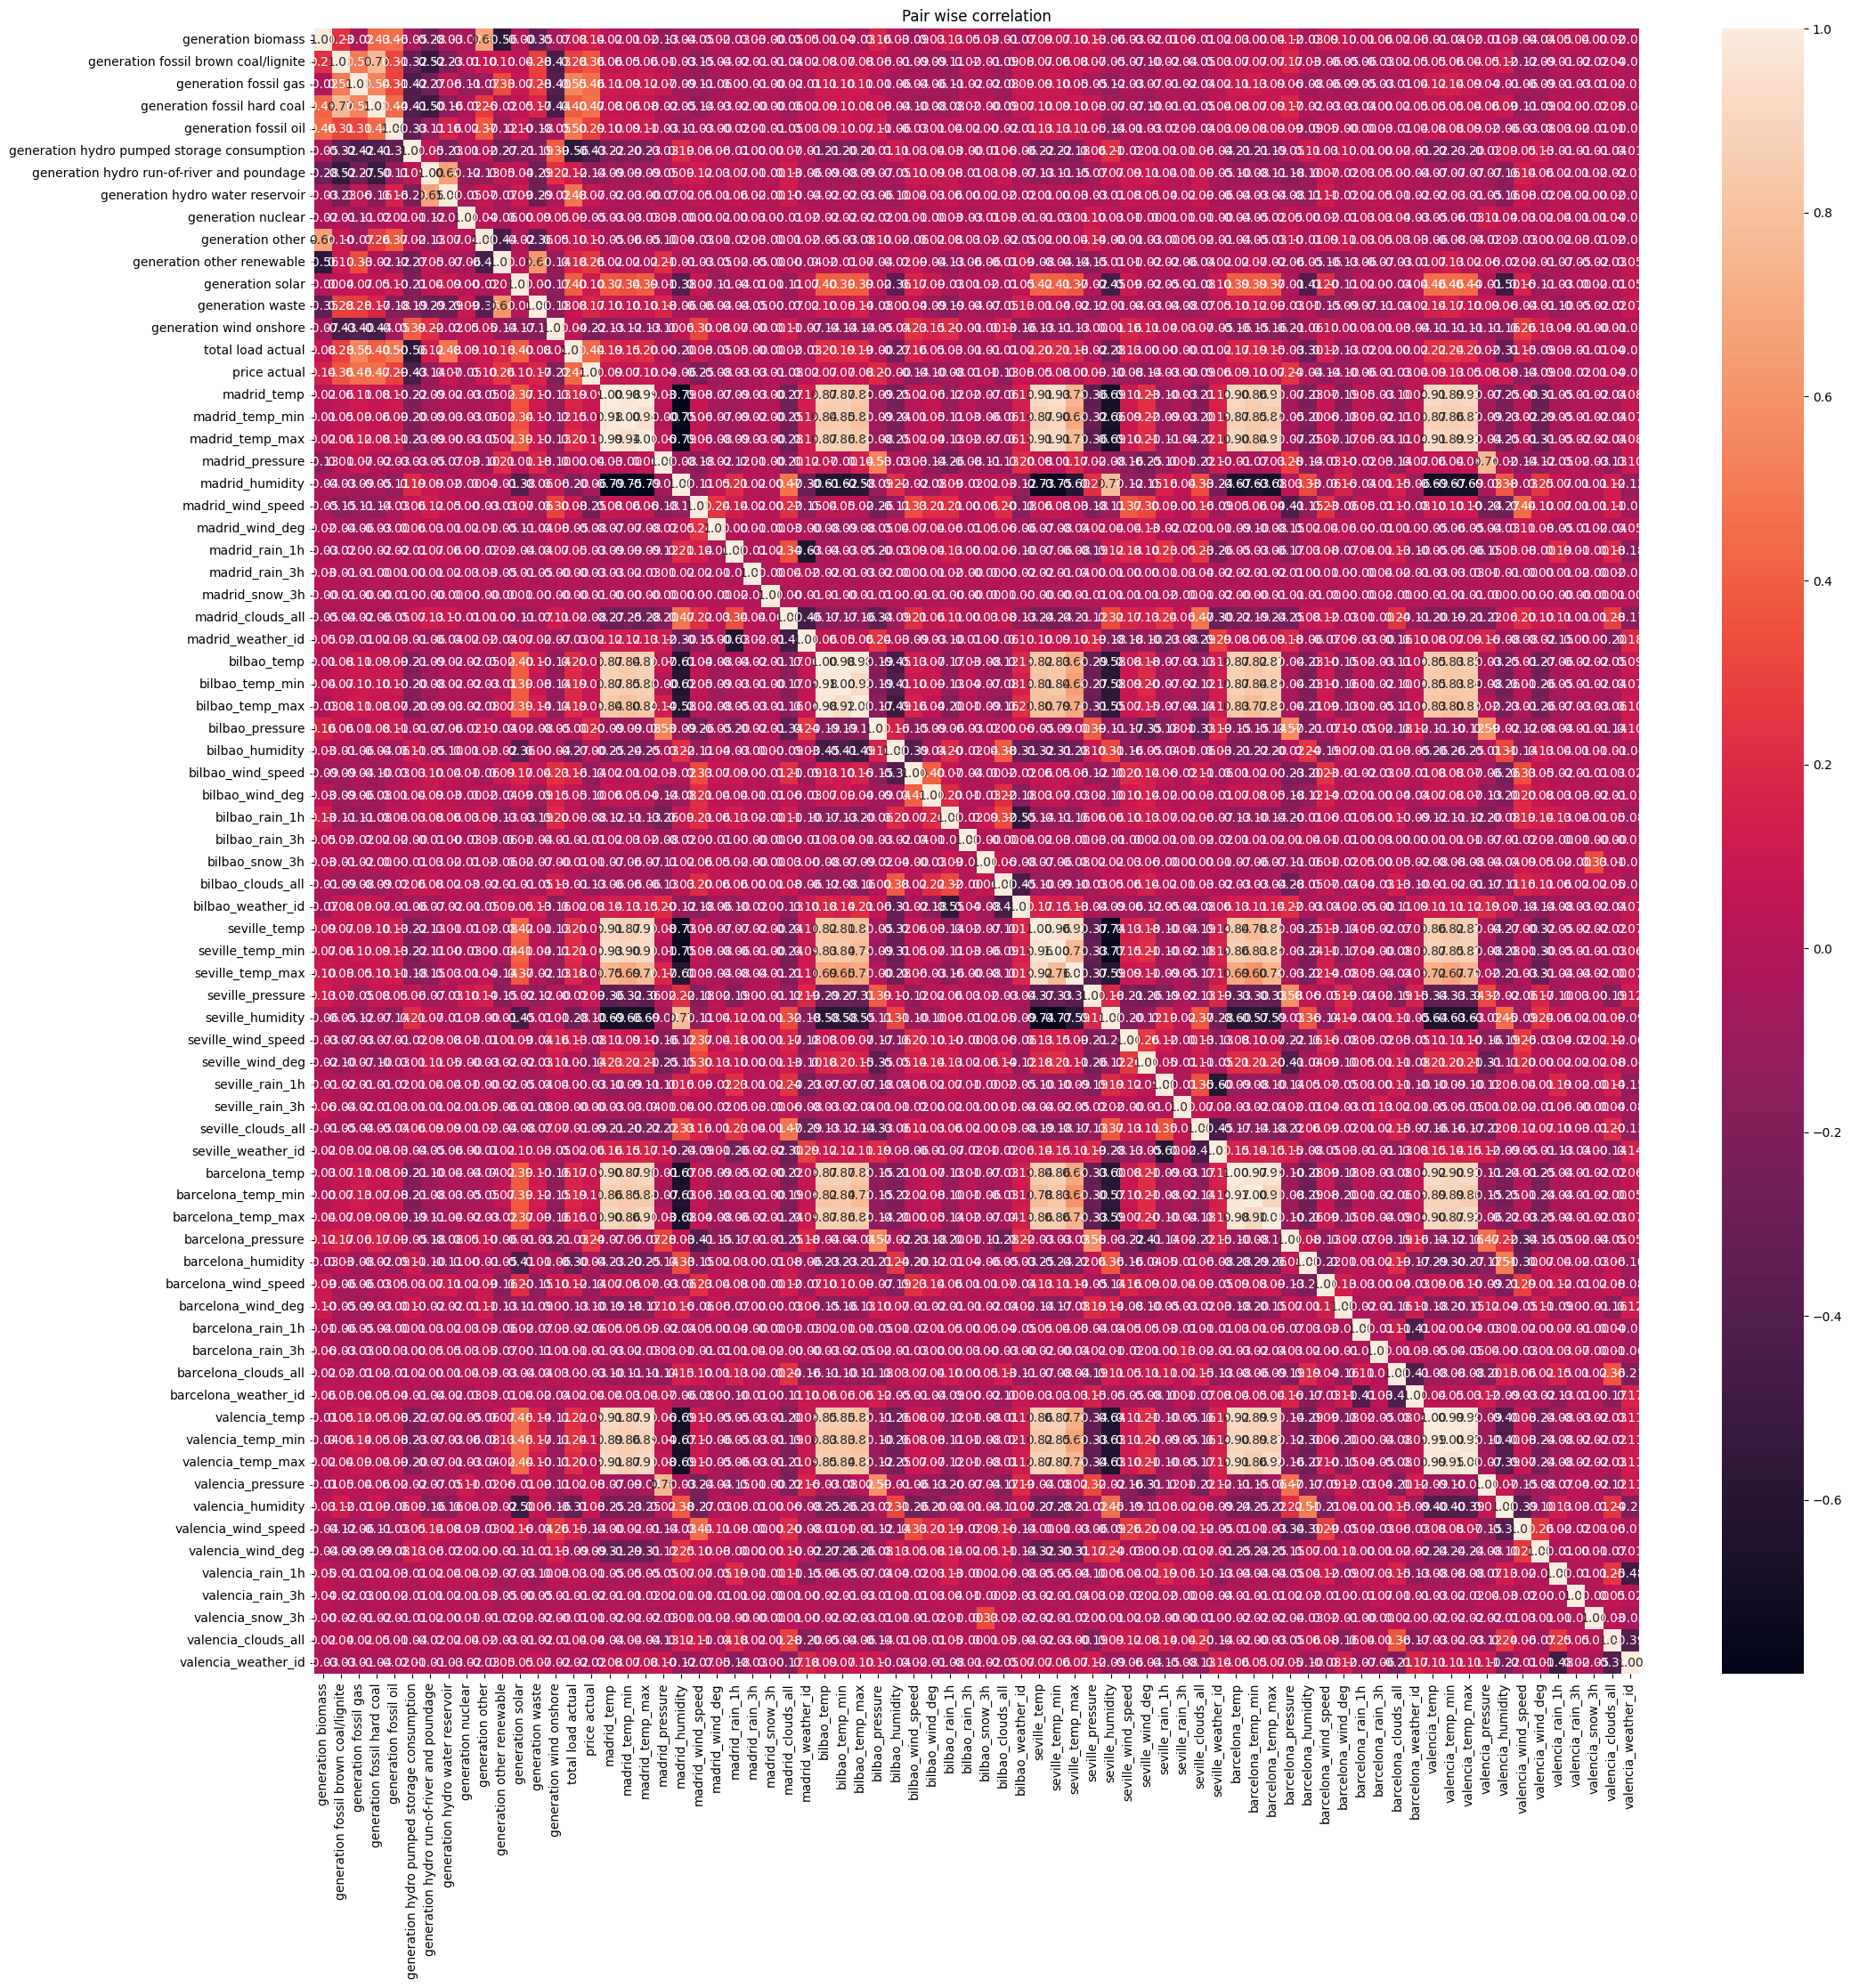

In [8]:
# Plot pair wise correlation matrix

correlations = energy_weather_df.corr(method='pearson')
fig = plt.figure(figsize=(24,24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pair wise correlation')
plt.show()

In [9]:

for i in range(len(energy_weather_df)):
    position = energy_weather_df.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    energy_weather_df.loc[position, 'hour'] = hour
    energy_weather_df.loc[position, 'weekday'] = weekday
    energy_weather_df.loc[position, 'month'] = month

In [10]:

for i in range(len(energy_weather_df)):
    position = energy_weather_df.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        energy_weather_df.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        energy_weather_df.loc[position, 'business hour'] = 1
    else:
        energy_weather_df.loc[position, 'business hour'] = 0

In [11]:
energy_weather_df.head(20)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price actual,madrid_temp,madrid_temp_min,madrid_temp_max,madrid_pressure,madrid_humidity,madrid_wind_speed,madrid_wind_deg,madrid_rain_1h,madrid_rain_3h,madrid_snow_3h,madrid_clouds_all,madrid_weather_id,bilbao_temp,bilbao_temp_min,bilbao_temp_max,bilbao_pressure,bilbao_humidity,bilbao_wind_speed,bilbao_wind_deg,bilbao_rain_1h,bilbao_rain_3h,bilbao_snow_3h,bilbao_clouds_all,bilbao_weather_id,seville_temp,seville_temp_min,seville_temp_max,seville_pressure,seville_humidity,seville_wind_speed,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_clouds_all,seville_weather_id,barcelona_temp,barcelona_temp_min,barcelona_temp_max,barcelona_pressure,barcelona_humidity,barcelona_wind_speed,barcelona_wind_deg,barcelona_rain_1h,barcelona_rain_3h,barcelona_clouds_all,barcelona_weather_id,valencia_temp,valencia_temp_min,valencia_temp_max,valencia_pressure,valencia_humidity,valencia_wind_speed,valencia_wind_deg,valencia_rain_1h,valencia_rain_3h,valencia_snow_3h,valencia_clouds_all,valencia_weather_id,hour,weekday,month,business hour
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,64.92,267.325000,267.325000,267.325000,980,63,1,309,0.0,0.0,0.0,0,800,269.763500,269.763500,269.763500,1035,97,0,229,0.0,0.0,0.0,0,800,273.375000,273.375000,273.375000,1039,75,1,21,0.0,0.0,0,800,281.625000,281.625000,281.625000,1035,100,7,58,0.0,0.0,0,800,270.475000,270.475000,270.475000,1001,77,1,62,0.0,0.0,0.0,0,800,0.0,3.0,1.0,0.0
2015-01-01 01:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,64.48,266.186000,266.186000,266.186000,980,64,1,273,0.0,0.0,0.0,0,800,269.251688,269.251688,269.251688,1036,97,1,224,0.0,0.0,0.0,0,800,274.086000,274.086000,274.086000,1039,71,3,27,0.0,0.0,0,800,281.286000,281.286000,281.286000,1036,100,7,48,0.0,0.0,0,800,269.686000,269.686000,269.686000,1002,78,0,23,0.0,0.0,0.0,0,800,1.0,3.0,1.0,0.0
2015-01-01 02:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,59.32,266.186000,266.186000,266.186000,980,64,1,273,0.0,0.0,0.0,0,800,269.203344,269.203344,269.203344,1035,97,1,225,0.0,0.0,0.0,0,800,274.086000,274.086000,274.086000,1039,71,3,27,0.0,0.0,0,800,281.286000,281.286000,281.286000,1036,100,7,48,0.0,0.0,0,800,269.686000,269.686000,269.686000,1002,78,0,23,0.0,0.0,0.0,0,800,2.0,3.0,1.0,0.0
2015-01-01 03:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,56.04,266.186000,266.186000,266.186000,980,64,1,273,0.0,0.0,0.0,0,800,269.485500,269.485500,269.485500,1035,97,1,221,0.0,0.0,0.0,0,800,274.086000,274.086000,274.086000,1039,71,3,27,0.0,0.0,0,800,281.286000,281.286000,281.286000,1036,100,7,48,0.0,0.0,0,800,269.686000,269.686000,269.686000,1002,78,0,23,0.0,0.0,0.0,0,800,3.0,3.0,1.0,0.0
2015-01-01 04:00:00,410.0,178.0,4038.0,3590.0,156.0,2109.0,952.0,743.0,7098.0,43.0,74.0,34.0,188.0,4618.0,19905.0,53.63,265.442000,265.442000,265.442000,980,64,0,240,0.0,0.0,0.0,0,800,269.327000,269.327000,269.327000,1035,97,1,224,0.0,0.0,0.0,0,800,274.592000,274.592000,274.592000,1039,81,4,57,0.0,0.0,0,800,280.467000,280.467000,280.467000,1037,100,5,32,0.0,0.0,0,800,270.292000,270.292000,270.292000,1004,71,2,321,0.0,0.0,0.0,0,800,4.0,3.0,1.0,0.0
2015-01-01 05:00:00,401.0,172.0,4040.0,3368.0,158.0,2108.0,961.0,848.0,7098.0,43.0,74.0,34.0,186.0,4397.0,20010.0,51.73,265.442000,265.442000,265.442000,980,64,0,240,0.0,0.0,0.0,0,800,269.499000,269.499000,269.499000,1035,97,1,222,0.0,0.

In [12]:
for i in range(len(energy_weather_df)):
    position = energy_weather_df.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        energy_weather_df.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        energy_weather_df.loc[position, 'weekday'] = 1
    else:
        energy_weather_df.loc[position, 'weekday'] = 0

In [15]:
energy_weather_df['generation coal all'] = energy_weather_df['generation fossil hard coal'] + energy_weather_df['generation fossil brown coal/lignite']
energy_weather_df.head(5)
energy_weather_df.shape

(35063, 79)

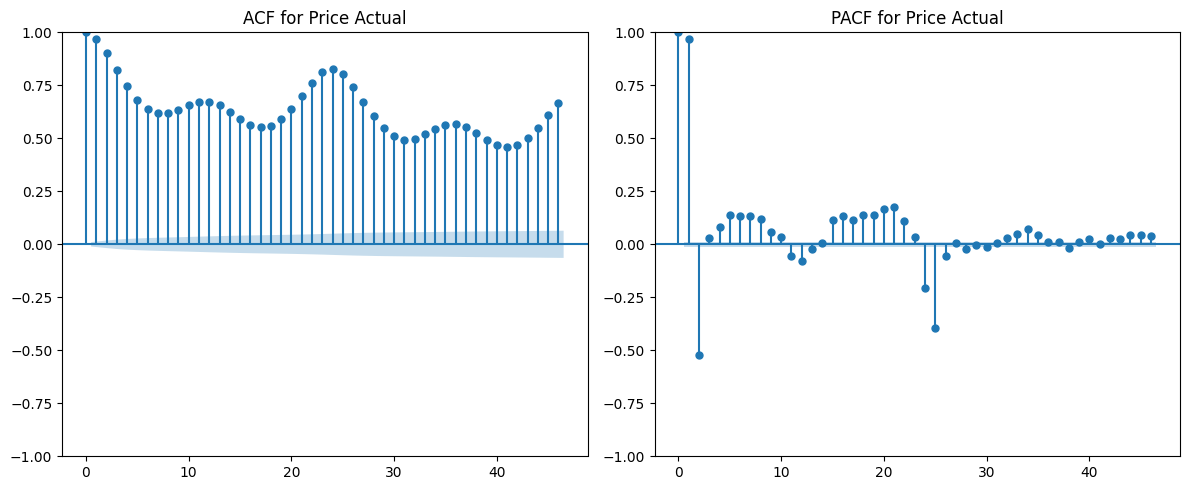

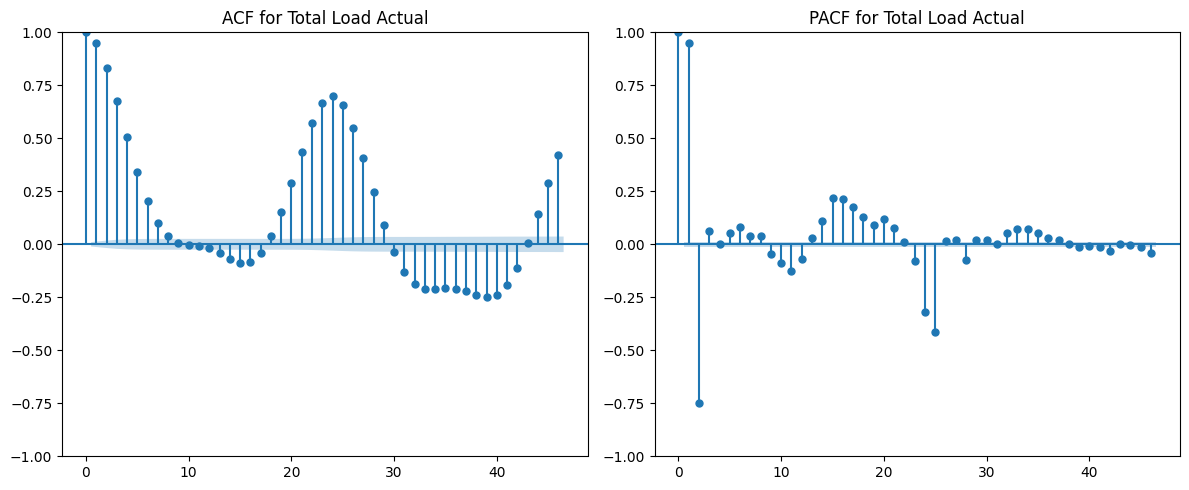

In [16]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'energy_weather_df' is your DataFrame and has 'price actual' and 'total load actual' columns

# ACF and PACF for "price actual"
price_series = energy_weather_df['price actual']
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(price_series.dropna(), ax=plt.gca(), title='ACF for Price Actual')
plt.subplot(122)
plot_pacf(price_series.dropna(), ax=plt.gca(), title='PACF for Price Actual', method='ywm')
plt.tight_layout()
plt.show()

# ACF and PACF for "total load actual"
load_series = energy_weather_df['total load actual']
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(load_series.dropna(), ax=plt.gca(), title='ACF for Total Load Actual')
plt.subplot(122)
plot_pacf(load_series.dropna(), ax=plt.gca(), title='PACF for Total Load Actual', method='ywm')
plt.tight_layout()
plt.show()


In [17]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [18]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35063


In [19]:
X = energy_weather_df[energy_weather_df.columns.drop('total load actual')].values
y = energy_weather_df['total load actual'].values

y = y.reshape(-1, 1)

In [20]:
print(energy_weather_df.iloc[1])

generation biomass                               448.000000
generation fossil brown coal/lignite             323.000000
generation fossil gas                           4857.000000
generation fossil hard coal                     4581.000000
generation fossil oil                            157.000000
generation hydro pumped storage consumption     1164.000000
generation hydro run-of-river and poundage       973.000000
generation hydro water reservoir                1371.000000
generation nuclear                              7099.000000
generation other                                  43.000000
generation other renewable                        73.000000
generation solar                                  50.000000
generation waste                                 196.000000
generation wind onshore                         5461.000000
total load actual                              22734.000000
price actual                                      64.480000
madrid_temp                             

In [21]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [22]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])


MinMaxScaler()

In [23]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [24]:
pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

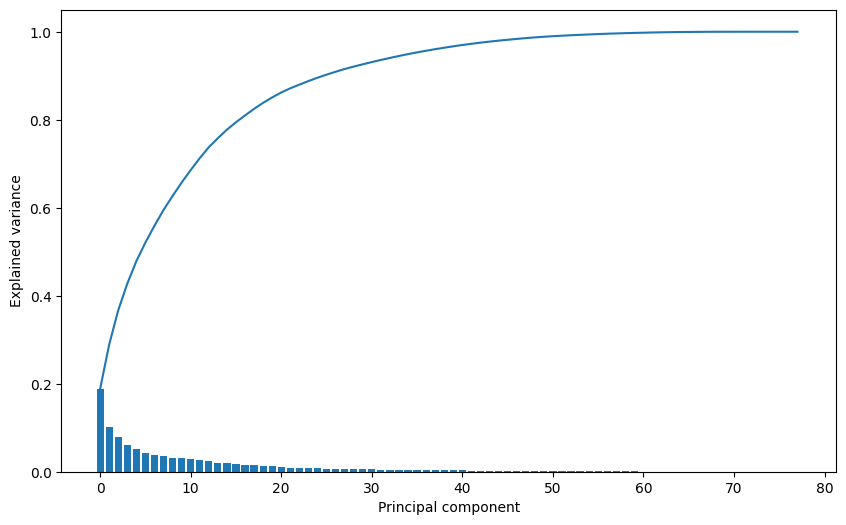

In [25]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [26]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

In [27]:
X_pca.shape

(35063, 17)

In [28]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0

In [29]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history,
                                     future_target, step=1, single_step=True)

In [30]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history,
                                 future_target, step=1, single_step=True)

In [31]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history,
                                   future_target, step=1, single_step=True)

In [32]:
batch_size = 32
buffer_size = 1000

In [33]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [34]:
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [35]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

In [36]:
def plot_model_rmse_and_loss(history):

    # Evaluate train and validation accuracies and losses

    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Visualize epochs vs. train and validation accuracies and losses

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

In [37]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [38]:
param = {'eta': 0.02, 'max_depth': 10,
         'subsample': 1.0, 'colsample_bytree': 0.95,
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse',
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)
eval_list = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(param, dtrain, 180, eval_list, early_stopping_rounds=3)

[0]	train-rmse:0.19502	eval-rmse:0.19413
[1]	train-rmse:0.19126	eval-rmse:0.19039
[2]	train-rmse:0.18757	eval-rmse:0.18673
[3]	train-rmse:0.18396	eval-rmse:0.18314
[4]	train-rmse:0.18042	eval-rmse:0.17961
[5]	train-rmse:0.17696	eval-rmse:0.17617
[6]	train-rmse:0.17357	eval-rmse:0.17281
[7]	train-rmse:0.17024	eval-rmse:0.16950
[8]	train-rmse:0.16699	eval-rmse:0.16626
[9]	train-rmse:0.16379	eval-rmse:0.16308
[10]	train-rmse:0.16067	eval-rmse:0.15996
[11]	train-rmse:0.15761	eval-rmse:0.15691
[12]	train-rmse:0.15462	eval-rmse:0.15393
[13]	train-rmse:0.15168	eval-rmse:0.15100
[14]	train-rmse:0.14889	eval-rmse:0.14820
[15]	train-rmse:0.14607	eval-rmse:0.14538
[16]	train-rmse:0.14331	eval-rmse:0.14262
[17]	train-rmse:0.14060	eval-rmse:0.13993
[18]	train-rmse:0.13795	eval-rmse:0.13730
[19]	train-rmse:0.13536	eval-rmse:0.13471
[20]	train-rmse:0.13282	eval-rmse:0.13219
[21]	train-rmse:0.13033	eval-rmse:0.12972
[22]	train-rmse:0.12799	eval-rmse:0.12737
[23]	train-rmse:0.12560	eval-rmse:0.12499
[2

In [39]:
from sklearn.metrics import mean_absolute_error
forecast = xgb_model.predict(dtest)
xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

rmse_xgb = sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))
print('RMSE of hour-ahead total load XGBoost forecast: {}'
      .format(round(rmse_xgb, 3)))

# Calculate the R² score
r2_xgb = r2_score(y_test_inv, xgb_forecast_inv)
print('R² of hour-ahead total load actual XGBoost forecast: {:.3f}'.format(r2_xgb))
# Calculate MAE
mae_xgb = mean_absolute_error(y_test_inv, xgb_forecast_inv)
print(f'MAE of hour-ahead total load actual XGBoost forecast: {round(mae_xgb, 3)}')

rmse_xgb = sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))
print('RMSE of forecast: {:.3f}'.format(rmse_xgb))

# Normalize the errors by the mean of the observed data
mean_y_test_inv = y_test_inv.mean()
nmae_xgb = mae_xgb / mean_y_test_inv
nrmse_xgb = rmse_xgb / mean_y_test_inv

print('Normalized MAE of forecast: {:.3f}'.format(nmae_xgb))
print('Normalized RMSE of forecast: {:.3f}'.format(nrmse_xgb))

RMSE of hour-ahead total load XGBoost forecast: 618.604
R² of hour-ahead total load actual XGBoost forecast: 0.982
MAE of hour-ahead total load actual XGBoost forecast: 436.67
RMSE of forecast: 618.604
Normalized MAE of forecast: 0.015
Normalized RMSE of forecast: 0.021


In [40]:

tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape,
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [ ]:
history = multivariate_lstm.fit(train, epochs=30,
                                validation_data=validation,
                                callbacks=[early_stopping,
                                           model_checkpoint])

In [ ]:
plot_model_rmse_and_loss(history)

In [ ]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead electricity price LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import numpy as np  # If not already imported


In [ ]:
# Assuming y_test_inv and lstm_forecast are already defined
# Calculate RMSE
rmse_lstm = sqrt(mean_squared_error(y_test_inv, lstm_forecast))
print('RMSE of hour-ahead electricity price LSTM forecast: {:.3f}'.format(rmse_lstm))

# Calculate MSE
mse_lstm = mean_squared_error(y_test_inv, lstm_forecast)
print('MSE of hour-ahead electricity price LSTM forecast: {:.3f}'.format(mse_lstm))

# Calculate MAE
mae_lstm = mean_absolute_error(y_test_inv, lstm_forecast)
print('MAE of hour-ahead electricity price LSTM forecast: {:.3f}'.format(mae_lstm))

# Calculate R² Score
r2_lstm = r2_score(y_test_inv, lstm_forecast)
print('R² of hour-ahead electricity price LSTM forecast: {:.3f}'.format(r2_lstm))

# Normalize RMSE and MSE by the mean of y_test_inv
mean_y_test_inv = np.mean(y_test_inv)
normalized_rmse_lstm = rmse_lstm / mean_y_test_inv
normalized_mse_lstm = mse_lstm / mean_y_test_inv

print('Normalized RMSE of hour-ahead electricity price LSTM forecast: {:.3f}'.format(normalized_rmse_lstm))
print('Normalized MSE of hour-ahead electricity price LSTM forecast: {:.3f}'.format(normalized_mse_lstm))
